<a href="https://colab.research.google.com/github/skolouri/TinyTransformer/blob/main/TinyTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal Transformer Encoder–Decoder

In this notebook, we build a minimal Transformer with both an encoder and a decoder:
- **Encoder:** Processes the source sequence.
- **Decoder:** Uses masked self-attention (to preserve causality) and cross-attention (to attend to the encoder output) to generate the target sequence.

We'll use sinusoidal positional encoding and basic modules (Multi-Head Attention and Feedforward networks) with residual connections and layer normalization. Finally, we test the model using dummy source and target token sequences.


## Building A Transformer One Block at a Time

### Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

# Check if GPU is available and set device accordingly (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Positional Encoding

Positional Encoding output shape: torch.Size([2, 10, 128])


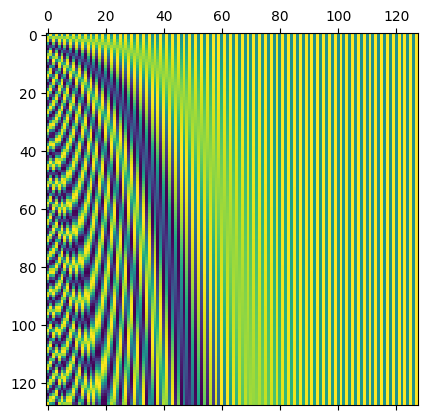

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: Dimensionality of the embeddings.
        max_len: Maximum length of the input sequences.
        """
        super().__init__()
        # Create a matrix of shape (max_len, d_model) with sinusoidal values
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices: sine
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices: cosine
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        Returns: x with positional encodings added.
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

# Test PositionalEncoding with dummy data
dummy_input = torch.zeros(2, 10, 128)  # batch_size=2, seq_len=10, d_model=32
pos_enc = PositionalEncoding(128)
print("Positional Encoding output shape:", pos_enc(dummy_input).shape)
plt.matshow(pos_enc.pe.squeeze()[:128,:])
plt.show()

### Multi-Head Attention

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        # Linear projections
        Q = self.W_q(query)  # (batch_size, seq_len, d_model)
        K = self.W_k(key)
        V = self.W_v(value)

        # Split into multiple heads and transpose for attention: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            # Expect mask of shape (seq_len, seq_len) or broadcastable to (batch_size, num_heads, seq_len, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, V)

        # Concatenate attention heads and run through final linear layer
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.fc(out)

# Quick test:
dummy_input = torch.rand(2, 10, 32)
mha = MultiHeadAttention(d_model=32, num_heads=4)
print("MultiHeadAttention output shape:", mha(dummy_input, dummy_input, dummy_input).shape)


MultiHeadAttention output shape: torch.Size([2, 10, 32])


### Feedforward Network

In [26]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        '''
        MLP with d_ff hidden units and dropout.
        d_model: Input dimension.
        d_ff: Hidden layer dimension.
        dropout: Dropout rate.
        '''
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Quick test:
ffn = FeedForward(d_model=32, d_ff=64)
print("FeedForward output shape:", ffn(dummy_input).shape)


FeedForward output shape: torch.Size([2, 10, 32])


### Transformer Encoder Layer

In [27]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.mha(x, x, x, mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feedforward network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)
        return x

# Quick test:
encoder_layer = TransformerEncoderLayer(d_model=32, num_heads=4, d_ff=64)
print("Encoder Layer output shape:", encoder_layer(dummy_input).shape)


Encoder Layer output shape: torch.Size([2, 10, 32])


### Transformer Decoder Layer

In [28]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        # Decoder's masked self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Cross-attention: queries come from decoder, keys & values from encoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, self_mask=None, cross_mask=None):
        # Masked self-attention (ensure each position can only attend to previous positions)
        self_attn_output = self.self_attn(x, x, x, self_mask)
        x = x + self.dropout1(self_attn_output)
        x = self.norm1(x)

        # Cross-attention with encoder output (keys and values come from encoder)
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, cross_mask)
        x = x + self.dropout2(cross_attn_output)
        x = self.norm2(x)

        # Feedforward network with residual connection
        ffn_output = self.ffn(x)
        x = x + self.dropout3(ffn_output)
        x = self.norm3(x)
        return x

# Quick test with dummy encoder output:
dummy_encoder_output = torch.rand(2,16, 32)
decoder_layer = TransformerDecoderLayer(d_model=32, num_heads=4, d_ff=64)
print("Decoder Layer output shape:", decoder_layer(dummy_input, dummy_encoder_output).shape)


Decoder Layer output shape: torch.Size([2, 10, 32])


###  Utility – Causal Mask Generation

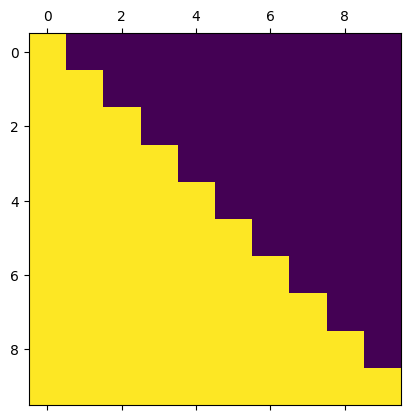

In [29]:
def generate_causal_mask(seq_len):
    """
    Generates a lower-triangular matrix of ones (allowed positions)
    and zeros in the upper triangle (masked positions).

    Returns:
        mask: Tensor of shape (seq_len, seq_len)
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask  # This mask will be broadcasted appropriately in attention computations.

# Quick test:
mask = generate_causal_mask(10)
plt.matshow(mask)
plt.show()


### Encoder and Decoder Stacks

In [47]:
# Transformer Encoder and Decoder Stacks
# ----------------------------------------
# These classes create stacks of encoder and decoder layers, respectively.
# The encoder and decoder layers (TransformerEncoderLayer and TransformerDecoderLayer)
# are assumed to be defined in previous cells.
#
# The stacks allow us to build deeper transformer models by repeating the same layer multiple times.
# Finally, a LayerNorm is applied to the final output to stabilize and normalize the activations.

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes a Transformer Encoder stack.

        Args:
            num_layers (int): Number of encoder layers to stack.
            d_model (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads in each encoder layer.
            d_ff (int): Dimensionality of the feedforward network within each encoder layer.
            dropout (float): Dropout probability for regularization.
        """
        super().__init__()
        # Create a list (ModuleList) of TransformerEncoderLayer instances.
        # Each layer in the list is identical in structure but has its own learnable parameters.
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        # Apply layer normalization at the end of the encoder stack.
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        """
        Pass the input through all encoder layers, sequentially.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            mask (Tensor, optional): Attention mask to be applied in each encoder layer.

        Returns:
            Tensor: The normalized output of the encoder stack.
        """
        # Iterate over each encoder layer and update the input x.
        for layer in self.layers:
            x = layer(x, mask)
        # Normalize the final output.
        return self.norm(x)

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes a Transformer Decoder stack.

        Args:
            num_layers (int): Number of decoder layers to stack.
            d_model (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads in each decoder layer.
            d_ff (int): Dimensionality of the feedforward network within each decoder layer.
            dropout (float): Dropout probability for regularization.
        """
        super().__init__()
        # Create a list (ModuleList) of TransformerDecoderLayer instances.
        # Each decoder layer handles both masked self-attention and cross-attention with encoder outputs.
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        # Apply layer normalization at the end of the decoder stack.
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, self_mask=None, cross_mask=None):
        """
        Pass the input through the decoder stack, incorporating encoder output.

        Args:
            x (Tensor): Decoder input tensor of shape (batch_size, tgt_seq_len, d_model).
            encoder_output (Tensor): Encoder output to be used for cross-attention.
            self_mask (Tensor, optional): Causal mask for the decoder's self-attention.
            cross_mask (Tensor, optional): Mask for the cross-attention (if needed).

        Returns:
            Tensor: The normalized output of the decoder stack.
        """
        # Iterate over each decoder layer and update the decoder's hidden state x.
        for layer in self.layers:
            x = layer(x, encoder_output, self_mask, cross_mask)
        # Normalize the final output.
        return self.norm(x)

print("\nTesting TransformerEncoder (Stack)...")
encoder_stack = TransformerEncoder(num_layers=2, d_model=32, num_heads=4, d_ff=64)
encoder_stack_out = encoder_stack(dummy_input)
assert encoder_stack_out.shape == dummy_input.shape, f"Expected shape {dummy_input.shape}, got {encoder_stack_out.shape}"
print("TransformerEncoder stack test passed:", encoder_stack_out.shape)

print("\nTesting TransformerDecoder (Stack)...")
dummy_decoder_input = torch.rand(2, 16, 32)
decoder_stack = TransformerDecoder(num_layers=2, d_model=32, num_heads=4, d_ff=64)
# Generate a causal mask for the decoder's self-attention.
# This mask prevents a position from attending to subsequent positions.
dummy_self_mask = generate_causal_mask(16)  # shape: (10, 10)
# For cross-attention, let's assume no masking is needed for simplicity.
# Alternatively, you could create a mask that marks padded tokens in the encoder output.
dummy_cross_mask = torch.ones(16, 10)  # All ones (no masking effect)
# Forward pass through the decoder stack with both self and cross attention masks applied
decoder_stack_out = decoder_stack(dummy_decoder_input, encoder_stack_out,
                                  self_mask=dummy_self_mask, cross_mask=dummy_cross_mask)

assert decoder_stack_out.shape == dummy_decoder_input.shape, \
    f"Expected shape {dummy_decoder_input.shape}, got {decoder_stack_out.shape}"
print("TransformerDecoder stack test with masks passed:", decoder_stack_out.shape)


Testing TransformerEncoder (Stack)...
TransformerEncoder stack test passed: torch.Size([2, 10, 32])

Testing TransformerDecoder (Stack)...
TransformerDecoder stack test with masks passed: torch.Size([2, 16, 32])


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=5000):
        super().__init__()
        self.d_model = d_model

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional Encoding (shared for src and tgt)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Encoder and Decoder stacks
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, dropout)

        # Generator: Final linear projection to produce logits for each vocabulary token
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src: Tensor of shape (batch_size, src_seq_len)
            tgt: Tensor of shape (batch_size, tgt_seq_len)
            src_mask: Optional mask for the source sequence (e.g., padding mask)
            tgt_mask: Optional mask for the target sequence (e.g., causal mask for self-attention)
        Returns:
            output: Logits of shape (batch_size, tgt_seq_len, tgt_vocab_size)
        """
        # Embed and scale the source tokens, then add positional encoding
        src_embedded = self.src_embedding(src) * math.sqrt(self.d_model)
        src_encoded = self.positional_encoding(src_embedded)
        encoder_output = self.encoder(src_encoded, src_mask)

        # Embed and scale the target tokens, then add positional encoding
        tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_encoded = self.positional_encoding(tgt_embedded)
        decoder_output = self.decoder(tgt_encoded, encoder_output, self_mask=tgt_mask, cross_mask=src_mask)

        # Generate logits for each token in the target vocabulary
        output = self.generator(decoder_output)
        return output

# For clarity, print a summary of the model (using dummy parameters)
src_vocab_size = 100  # Example vocab size for source
tgt_vocab_size = 100  # Example vocab size for target
d_model = 32
num_layers = 2
num_heads = 4
d_ff = 64

model = TransformerModel(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff).to(device)
print(model)
